# Feature Selection

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

data = pd.read_csv('data_processed/complete/enc_data.csv')

_data = data.copy()

pd.set_option('display.max_columns', None)

display(data.head())

SELECT_WRAPPED = True
REMOVE_HIGH_CORRELATED = True

,status,loan_id,account_id,loan_amount,loan_duration,loan_payments,account_district_id,disp_id,client_id,has_disponent,client_district_id,gender,last_balance,mean_balance,min_balance,negative_balance,monthly_diff,code,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth,has_card,age_on_loan_request,age_on_loan_request_disc,loan_payments_disc,monthly_diff_disc,a_freq_issuance_after_transaction,a_freq_monthly_issuance,a_freq_weekly_issuance
0,-1,5314,1787,96396,12,8033,30,2166,2166,False,30,0.0,20100.0,12250.000000,1100.0,0.0,6700,30,7.0,15,13,10,10,0.818,9650,0.100,0.29,-0.001909,False,46,3.0,4.0,4.0,0.0,0.0,1.0
1,1,5316,1801,165960,36,4610,46,2181,2181,False,46,1.0,52208.9,52083.859459,700.0,0.0,14733,46,2.0,48,20,10,10,0.735,8369,0.117,0.52,-0.002094,False,25,1.0,2.0,4.0,0.0,1.0,0.0
2,1,6863,9188,127080,60,2118,45,11006,11314,False,45,1.0,20272.8,30060.954167,800.0,0.0,-6859,45,2.0,85,19,7,5,0.535,8390,0.132,0.61,0.000539,False,57,4.0,0.0,2.0,0.0,1.0,0.0
3,1,5325,1843,105804,36,2939,12,2235,2235,False,14,0.0,34292.7,41297.480000,1000.0,0.0,-11054,14,5.0,69,27,11,9,0.748,10045,0.135,0.29,-0.001739,False,53,4.0,1.0,2.0,0.0,1.0,0.0
4,1,7240,11013,274740,60,4579,1,13231,13539,False,63,1.0,41142.9,57188.211111,600.0,0.0,-30531,63,6.0,38,36,6,5,0.505,8288,0.110,0.73,-0.001179,False,15,0.0,2.0,1.0,0.0,0.0,1.0


In [2]:
def get_features(df):
    return df.drop('status', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['status']), axis=1)

### Remove unecessary features

In [3]:
no_ids = [c for c in data.columns if c[-3:] != '_id' and c != 'code']
data = data[no_ids]
# data.drop(['account_frequency', 'gender', 'card_type'], axis=1, inplace=True)

display(data.head())
display(data.info())

,status,loan_amount,loan_duration,loan_payments,has_disponent,gender,last_balance,mean_balance,min_balance,negative_balance,monthly_diff,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth,has_card,age_on_loan_request,age_on_loan_request_disc,loan_payments_disc,monthly_diff_disc,a_freq_issuance_after_transaction,a_freq_monthly_issuance,a_freq_weekly_issuance
0,-1,96396,12,8033,False,0.0,20100.0,12250.000000,1100.0,0.0,6700,7.0,15,13,10,10,0.818,9650,0.100,0.29,-0.001909,False,46,3.0,4.0,4.0,0.0,0.0,1.0
1,1,165960,36,4610,False,1.0,52208.9,52083.859459,700.0,0.0,14733,2.0,48,20,10,10,0.735,8369,0.117,0.52,-0.002094,False,25,1.0,2.0,4.0,0.0,1.0,0.0
2,1,127080,60,2118,False,1.0,20272.8,30060.954167,800.0,0.0,-6859,2.0,85,19,7,5,0.535,8390,0.132,0.61,0.000539,False,57,4.0,0.0,2.0,0.0,1.0,0.0
3,1,105804,36,2939,False,0.0,34292.7,41297.480000,1000.0,0.0,-11054,5.0,69,27,11,9,0.748,10045,0.135,0.29,-0.001739,False,53,4.0,1.0,2.0,0.0,1.0,0.0
4,1,274740,60,4579,False,1.0,41142.9,57188.211111,600.0,0.0,-30531,6.0,38,36,6,5,0.505,8288,0.110,0.73,-0.001179,False,15,0.0,2.0,1.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 29 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   status                                           328 non-null    int64  
 1   loan_amount                                      328 non-null    int64  
 2   loan_duration                                    328 non-null    int64  
 3   loan_payments                                    328 non-null    int64  
 4   has_disponent                                    328 non-null    bool   
 5   gender                                           328 non-null    float64
 6   last_balance                                     328 non-null    float64
 7   mean_balance                                     328 non-null    float64
 8   min_balance                                      328 non-null    float64
 9   negative_balance                

None

### Remove high correlated

In [4]:
if REMOVE_HIGH_CORRELATED:
    cor_matrix = data.corr().abs()
    # display(cor_matrix)

    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    # display(upper_tri)

    cols = list(upper_tri.columns)
    cols.reverse()
    to_drop = [column for column in cols if any(abs(upper_tri[column]) > 0.85)]
    display(to_drop)

    data.drop(to_drop, axis=1, inplace=True)
    display(data.head())


/tmp/ipykernel_34851/357119512.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


['monthly_diff_disc', 'loan_payments_disc', 'age_on_loan_request_disc']

,status,loan_amount,loan_duration,loan_payments,has_disponent,gender,last_balance,mean_balance,min_balance,negative_balance,monthly_diff,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth,has_card,age_on_loan_request,a_freq_issuance_after_transaction,a_freq_monthly_issuance,a_freq_weekly_issuance
0,-1,96396,12,8033,False,0.0,20100.0,12250.000000,1100.0,0.0,6700,7.0,15,13,10,10,0.818,9650,0.100,0.29,-0.001909,False,46,0.0,0.0,1.0
1,1,165960,36,4610,False,1.0,52208.9,52083.859459,700.0,0.0,14733,2.0,48,20,10,10,0.735,8369,0.117,0.52,-0.002094,False,25,0.0,1.0,0.0
2,1,127080,60,2118,False,1.0,20272.8,30060.954167,800.0,0.0,-6859,2.0,85,19,7,5,0.535,8390,0.132,0.61,0.000539,False,57,0.0,1.0,0.0
3,1,105804,36,2939,False,0.0,34292.7,41297.480000,1000.0,0.0,-11054,5.0,69,27,11,9,0.748,10045,0.135,0.29,-0.001739,False,53,0.0,1.0,0.0
4,1,274740,60,4579,False,1.0,41142.9,57188.211111,600.0,0.0,-30531,6.0,38,36,6,5,0.505,8288,0.110,0.73,-0.001179,False,15,0.0,0.0,1.0


### Define model

In [5]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

def make_pipeline(classifier, smote = False):
    steps = []
    if smote: steps.append(['smote', SMOTE(random_state=11)])
    steps.append(['classifier', classifier])
    return imbpipeline(steps = steps)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

estimator = make_pipeline(RandomForestClassifier(), smote = False)

## Feature Selection
### Wrapper Method
Split Data into subsets and train a model using this. Based on the output of the model, add or subtract features and train the model again.
#### 1. Forward Selection

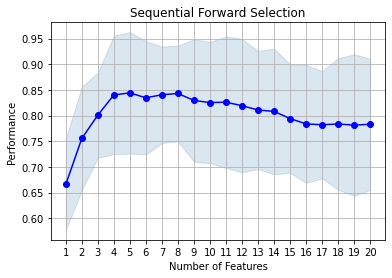

In [7]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

x = get_features(data)
y = data['status']

def forward_selection(features, target, k_features = 20):
    sfs = SFS(estimator,
              k_features=k_features,
              forward=True,
              floating=False,
              cv = 5,
              scoring = 'roc_auc',
              n_jobs = -1)
    sfs = sfs.fit(features, target)
    fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
    plt.title('Sequential Forward Selection')
    plt.grid()
    plt.show()
    return pd.DataFrame.from_dict(sfs.get_metric_dict()).T

if SELECT_WRAPPED:
    forward_selection_result = forward_selection(x, y)
    forward_selection_result

#### 2. Backward Elimination

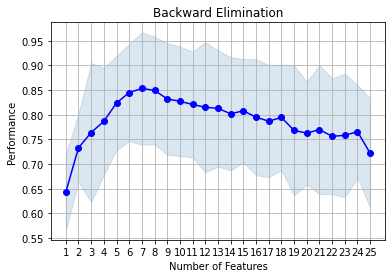

In [8]:
def backward_selection(features, target, k_features = 1):
    sbs = SFS(estimator,
              k_features=k_features,
              forward=False,
              floating=False,
              scoring = 'roc_auc',
              cv = 5,
              n_jobs = -1)
    sbs = sbs.fit(features, target)
    fig1 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
    plt.title('Backward Elimination')
    plt.grid()
    plt.show()
    return pd.DataFrame.from_dict(sbs.get_metric_dict()).T

if SELECT_WRAPPED:
    backward_selection_result = backward_selection(x, y)
    backward_selection_result

#### 3. Bi-directional Elimination (Step-wise Selection)

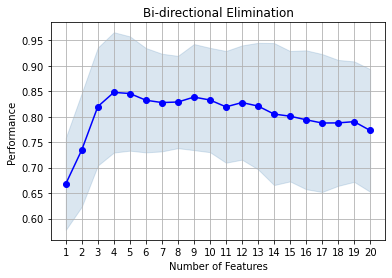

In [9]:
def bi_directional_elimination(features, target, k_features = (1,20)):
    sffs = SFS(estimator,
              k_features=k_features,
              forward=True,
              floating=True,
              scoring = 'roc_auc',
              cv = 5,
              n_jobs = -1)
    sffs = sffs.fit(features, target)
    fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')
    plt.title('Bi-directional Elimination')
    plt.grid()
    plt.show()
    return pd.DataFrame.from_dict(sffs.get_metric_dict()).T

if SELECT_WRAPPED:
    bi_directional_elimination_result = bi_directional_elimination(x, y)
    bi_directional_elimination_result

### Overview of the methods
#### Comparison

In [10]:
if SELECT_WRAPPED:
    # Change 'avg_score' to float
    forward_selection_result['avg_score'] = forward_selection_result['avg_score'].astype(float)
    backward_selection_result['avg_score'] = backward_selection_result['avg_score'].astype(float)
    bi_directional_elimination_result['avg_score'] = bi_directional_elimination_result['avg_score'].astype(float)

    # Find the best result for each method
    a = forward_selection_result.iloc[forward_selection_result['avg_score'].idxmax()]
    b = backward_selection_result.iloc[backward_selection_result['avg_score'].idxmax()]
    c = bi_directional_elimination_result.iloc[bi_directional_elimination_result['avg_score'].idxmax()]

    c_df = pd.DataFrame({
        'method': ['forward selection', 'backward elimination', 'bi-directional'],
        'feature_names': [a['feature_names'], b['feature_names'], c['feature_names']],
        'n_features': [len(a['feature_names']), len(b['feature_names']), len(c['feature_names'])],
        'avg_score': [a['avg_score'], b['avg_score'], c['avg_score']]  
    })

    display(c_df)

,method,feature_names,n_features,avg_score
0,forward selection,"(loan_payments, has_disponent, mean_balance, n...",6,0.834498
1,backward elimination,"(loan_amount, loan_duration, loan_payments, ha...",18,0.794765
2,bi-directional,"(loan_payments, has_disponent, mean_balance, n...",5,0.845515


#### Selection

In [11]:
if SELECT_WRAPPED:
    best_features_names = c_df.iloc[c_df['avg_score'].idxmax()]['feature_names']
    print('Best features: ', best_features_names)
    
    best_feature = []
    for feature_name in best_features_names:
        best_feature.append(data[feature_name])
    best_feature = pd.DataFrame(best_feature).T
    best_feature

Best features:  ('loan_payments', 'has_disponent', 'mean_balance', 'negative_balance', 'monthly_diff')


## Save

In [12]:
features = features = ['loan_amount', 'loan_payments', 'has_disponent', 'mean_balance', 'min_balance', 'negative_balance', 'monthly_diff', 'a_freq_monthly_issuance', 'a_freq_weekly_issuance']
if SELECT_WRAPPED:
    features = list(best_features_names)

features_selected = pd.concat([data[features], _data['status']], axis=1)
features_selected = pd.concat([_data['loan_id'], features_selected], axis=1)
features_selected.to_csv('data_processed/complete/data_selected.csv', index=False)